<a href="https://colab.research.google.com/github/DrVenkataRajeshKumar/S6/blob/master/With%20L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [194]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:

import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
    # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) 
        

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8


        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 



    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)        
        x = self.convblock7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [196]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 10, 10]             576
             ReLU-11            [-1, 8, 10, 10]               0
      BatchNorm2d-12            [-1, 8, 10, 10]              16
          Dropout-13            [-1, 8, 10, 10]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [198]:
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

model =  Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.95, patience=0, verbose=True)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.08929487317800522 Batch_id=468 Accuracy=94.12: 100%|██████████| 469/469 [00:15<00:00, 30.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 9857/10000 (98.57%)

EPOCH: 1


Loss=0.07264406234025955 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:15<00:00, 31.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0357, Accuracy: 9887/10000 (98.87%)

EPOCH: 2


Loss=0.020305447280406952 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:15<00:00, 30.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9904/10000 (99.04%)

EPOCH: 3


Loss=0.05873776972293854 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:14<00:00, 31.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9901/10000 (99.01%)

EPOCH: 4


Loss=0.05462351068854332 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:15<00:00, 30.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9926/10000 (99.26%)

EPOCH: 5


Loss=0.05704962834715843 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:15<00:00, 30.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9905/10000 (99.05%)

EPOCH: 6


Loss=0.034514278173446655 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:14<00:00, 31.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9899/10000 (98.99%)

EPOCH: 7


Loss=0.011787046678364277 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:14<00:00, 31.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9926/10000 (99.26%)

EPOCH: 8


Loss=0.07992322742938995 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:14<00:00, 31.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9934/10000 (99.34%)

EPOCH: 9


Loss=0.012813975103199482 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:14<00:00, 40.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9937/10000 (99.37%)

EPOCH: 10


Loss=0.03836322948336601 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:14<00:00, 39.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.03826111555099487 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:14<00:00, 31.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9924/10000 (99.24%)

EPOCH: 12


Loss=0.054321419447660446 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 31.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9933/10000 (99.33%)

EPOCH: 13


Loss=0.035553574562072754 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:14<00:00, 32.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9947/10000 (99.47%)

EPOCH: 14


Loss=0.059770625084638596 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:14<00:00, 32.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9934/10000 (99.34%)

EPOCH: 15


Loss=0.010127131827175617 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:14<00:00, 32.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9928/10000 (99.28%)

EPOCH: 16


Loss=0.01166321337223053 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:14<00:00, 31.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9936/10000 (99.36%)

EPOCH: 17


Loss=0.07015461474657059 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:14<00:00, 33.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9935/10000 (99.35%)

EPOCH: 18


Loss=0.012466013431549072 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:14<00:00, 32.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9935/10000 (99.35%)

EPOCH: 19


Loss=0.012867480516433716 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:14<00:00, 32.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9941/10000 (99.41%)

EPOCH: 20


Loss=0.21191103756427765 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:13<00:00, 33.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9945/10000 (99.45%)

EPOCH: 21


Loss=0.027289824560284615 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:14<00:00, 33.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9944/10000 (99.44%)

EPOCH: 22


Loss=0.023227065801620483 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:14<00:00, 32.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9935/10000 (99.35%)

EPOCH: 23


Loss=0.005563413258641958 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:14<00:00, 39.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9934/10000 (99.34%)

EPOCH: 24


Loss=0.07845878601074219 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 33.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9942/10000 (99.42%)

EPOCH: 25


Loss=0.0016523301601409912 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 32.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9943/10000 (99.43%)

EPOCH: 26


Loss=0.053090859204530716 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 33.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9939/10000 (99.39%)

EPOCH: 27


Loss=0.0030212700366973877 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:14<00:00, 33.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9943/10000 (99.43%)

EPOCH: 28


Loss=0.07817583531141281 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 33.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9943/10000 (99.43%)

EPOCH: 29


Loss=0.016044219955801964 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:14<00:00, 33.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9953/10000 (99.53%)

EPOCH: 30


Loss=0.016118645668029785 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 32.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9948/10000 (99.48%)

EPOCH: 31


Loss=0.010820035822689533 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:13<00:00, 34.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 9952/10000 (99.52%)

EPOCH: 32


Loss=0.06393875926733017 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:13<00:00, 33.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9950/10000 (99.50%)

EPOCH: 33


Loss=0.00968905258923769 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 33.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9951/10000 (99.51%)

EPOCH: 34


Loss=0.013999189250171185 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 32.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 9959/10000 (99.59%)

EPOCH: 35


Loss=0.0380965918302536 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:13<00:00, 34.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9940/10000 (99.40%)

EPOCH: 36


Loss=0.02392706274986267 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 32.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9941/10000 (99.41%)

EPOCH: 37


Loss=0.06421162188053131 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:13<00:00, 33.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9940/10000 (99.40%)

EPOCH: 38


Loss=0.12961681187152863 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:13<00:00, 41.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9935/10000 (99.35%)

EPOCH: 39


Loss=0.03520755097270012 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:13<00:00, 41.69it/s]



Test set: Average loss: 0.0183, Accuracy: 9949/10000 (99.49%)



# Let's Train and test our model

This time let's add a scheduler for out LR. 

Text(0.5, 1.0, 'Test Accuracy')

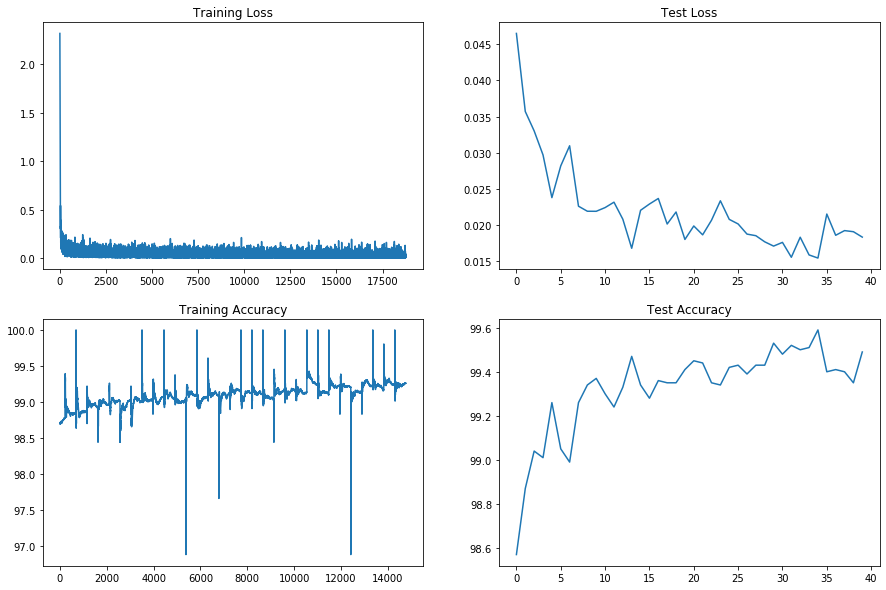

In [199]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

batchmates Mounika, Meenakshi, Vivek